## Machine learning project - Urban air pollution

In [1]:
# Import libraries for data visualization and data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

RSEED = 42

In [2]:
# Import data
air_pollution = pd.read_csv("data/Train.csv")

In [3]:
# Check data
air_pollution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 82 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Place_ID X Date                                      30557 non-null  object 
 1   Date                                                 30557 non-null  object 
 2   Place_ID                                             30557 non-null  object 
 3   target                                               30557 non-null  float64
 4   target_min                                           30557 non-null  float64
 5   target_max                                           30557 non-null  float64
 6   target_variance                                      30557 non-null  float64
 7   target_count                                         30557 non-null  int64  
 8   precipitable_water_entire_atmosphere                 30557 non-nul

In [4]:
# Check data for nan's
nan_count = air_pollution.isna().sum()
nan_percent = air_pollution.isna().sum()/len(air_pollution)*100

pd.options.display.max_rows = 4000
#print(nan_count)
#print(nan_percent)

In [5]:
# Create two dataframes from data:
# 1) Complete dataframe (contains all numerical features)
# 2) Incomplete dataframe (contains not all numerical features)
feature_set1 = [
'Place_ID X Date', 
'Date', 
'Place_ID',
'target', 
'target_min', 
'target_max', 
'target_variance', 
'target_count']

feature_set2 = [
'Place_ID X Date', 
'Date', 
'Place_ID', 
'target', 
'target_min', 
'target_max', 
'target_variance', 
'target_count', 
'L3_NO2_sensor_altitude', 
'L3_NO2_sensor_azimuth_angle', 
'L3_NO2_sensor_zenith_angle', 
'L3_NO2_solar_azimuth_angle', 
'L3_NO2_solar_zenith_angle', 
'L3_O3_sensor_azimuth_angle', 
'L3_O3_sensor_zenith_angle', 
'L3_O3_solar_azimuth_angle', 
'L3_O3_solar_zenith_angle', 
'L3_CO_sensor_altitude',
'L3_CO_sensor_azimuth_angle',
'L3_CO_sensor_zenith_angle',
'L3_CO_solar_azimuth_angle',
'L3_CO_solar_zenith_angle',
'L3_HCHO_solar_azimuth_angle',
'L3_HCHO_solar_zenith_angle',
'L3_HCHO_sensor_azimuth_angle',
'L3_HCHO_sensor_zenith_angle',
'L3_AER_AI_sensor_altitude',
'L3_AER_AI_sensor_azimuth_angle',
'L3_AER_AI_sensor_zenith_angle',
'L3_AER_AI_solar_azimuth_angle',
'L3_AER_AI_solar_zenith_angle',
'L3_CLOUD_sensor_azimuth_angle',
'L3_CLOUD_sensor_zenith_angle',
'L3_CLOUD_solar_azimuth_angle',
'L3_CLOUD_solar_zenith_angle',
'L3_SO2_sensor_azimuth_angle',
'L3_SO2_sensor_zenith_angle',
'L3_SO2_solar_azimuth_angle',
'L3_SO2_solar_zenith_angle',
'L3_CH4_CH4_column_volume_mixing_ratio_dry_air',
'L3_CH4_aerosol_height',
'L3_CH4_aerosol_optical_depth',
'L3_CH4_sensor_azimuth_angle',
'L3_CH4_sensor_zenith_angle',
'L3_CH4_solar_azimuth_angle',
'L3_CH4_solar_zenith_angle']

complete_df = air_pollution.drop(feature_set1, axis=1)
incomplete_df = air_pollution.drop(feature_set2, axis=1)

In [6]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 74 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   precipitable_water_entire_atmosphere                 30557 non-null  float64
 1   relative_humidity_2m_above_ground                    30557 non-null  float64
 2   specific_humidity_2m_above_ground                    30557 non-null  float64
 3   temperature_2m_above_ground                          30557 non-null  float64
 4   u_component_of_wind_10m_above_ground                 30557 non-null  float64
 5   v_component_of_wind_10m_above_ground                 30557 non-null  float64
 6   L3_NO2_NO2_column_number_density                     28368 non-null  float64
 7   L3_NO2_NO2_slant_column_number_density               28368 non-null  float64
 8   L3_NO2_absorbing_aerosol_index                       28368 non-nul

In [7]:
incomplete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 36 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   precipitable_water_entire_atmosphere                 30557 non-null  float64
 1   relative_humidity_2m_above_ground                    30557 non-null  float64
 2   specific_humidity_2m_above_ground                    30557 non-null  float64
 3   temperature_2m_above_ground                          30557 non-null  float64
 4   u_component_of_wind_10m_above_ground                 30557 non-null  float64
 5   v_component_of_wind_10m_above_ground                 30557 non-null  float64
 6   L3_NO2_NO2_column_number_density                     28368 non-null  float64
 7   L3_NO2_NO2_slant_column_number_density               28368 non-null  float64
 8   L3_NO2_absorbing_aerosol_index                       28368 non-nul

In [8]:
# TODO Decide which features should be analyzed
feature_set = "complete"
#feature_set = "incomplete"

if feature_set == "complete":
    df = complete_df
if feature_set == "incomplete":
    df = incomplete_df

#df.info()
print("Feature shape:", df.shape)    

Feature shape: (30557, 74)


## Data preprocessing

### Multicollinearity (feature reduction)

In [9]:
# Remove highly correlated features from feature space to avoid multicollinearity
# Highly correlated features defined as: Correlation coefficient > 0.7

# Create correlation matrix
correlation_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Remove features with correlation greater than 0.7
df = df.drop(to_drop, axis=1)

#df.info()
print("Feature shape:", df.shape) 

Feature shape: (30557, 25)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 25 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   precipitable_water_entire_atmosphere                 30557 non-null  float64
 1   relative_humidity_2m_above_ground                    30557 non-null  float64
 2   u_component_of_wind_10m_above_ground                 30557 non-null  float64
 3   v_component_of_wind_10m_above_ground                 30557 non-null  float64
 4   L3_NO2_NO2_column_number_density                     28368 non-null  float64
 5   L3_NO2_absorbing_aerosol_index                       28368 non-null  float64
 6   L3_NO2_cloud_fraction                                28368 non-null  float64
 7   L3_NO2_sensor_altitude                               28368 non-null  float64
 8   L3_NO2_sensor_azimuth_angle                          28367 non-nul

## Data analysis

### Split data in train and test set 

In [10]:
# Define features and target and split data into train and test set
X = df
y = air_pollution["target"]

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED)

# Bug report: train_test_split(stratify=y) does not work! Why?

In [11]:
print(f"Our feature vector has {X.shape[0]} observations and {X.shape[1]} features")
print(f"Our target vector has {y.shape[0]} observations")

Our feature vector has 30557 observations and 25 features
Our target vector has 30557 observations


### Normalization (target)

In [12]:
# Normalize target using MinMaxScaler()
get_target_train = y_train.values.reshape(-1,1)
get_target_test = y_test.values.reshape(-1,1)

scaler = MinMaxScaler()

y_train_fit = scaler.fit(get_target_train)
y_train = pd.DataFrame(y_train_fit.transform(get_target_train))
y_test = pd.DataFrame(y_train_fit.transform(get_target_test))


### Train models

In [13]:
# Create pipeline to impute and scale feature values
num_pipeline = Pipeline([
    ('median_imputer', SimpleImputer(strategy='median')),
    ('minmax_scaler', MinMaxScaler())
])

num_features = X_train.columns

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features)
])

# Create pipeline to start modelling
# Model initiation: Linear regressor
pipe_linreg = Pipeline([
    ('preprocessor', preprocessor),
    ('linreg', LinearRegression())
])

# Model initiation: KNN regressor
pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor())
])

# Model initiation: Decision tree
pipe_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeRegressor())
])

# Model initiation: Random forest
pipe_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('forest', RandomForestRegressor())
])

In [ ]:
# Check: Model performance on train set (without hyperparameter tuning) 
y_train_pred = cross_val_predict(pipe_linreg, X_train, y_train, cv=5)
#y_train_pred = cross_val_predict(pipe_knn, X_train, y_train, cv=5)
#y_train_pred = cross_val_predict(pipe_tree, X_train, y_train, cv=5)
#y_train_pred = cross_val_predict(pipe_forest, X_train, y_train, cv=5)

rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print("Training")
print("RSME: ", rmse)
print("_"*10)

In [14]:
# Hyperparameter tuning 

# Define hyperparameter search space for GridSearch
param_knn = {'knn__n_neighbors': [5, 7, 9, 11, 13],
             'knn__weights': ['uniform', 'distance'],
             'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  
            }

param_tree = {'tree__max_depth': [10, 50, 100],
              'tree__min_samples_leaf': np.arange(5,55,10),
              'tree__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
              }

param_forest = {'forest__n_estimators': np.arange(50,200,50),
                'forest__max_depth': [5, 10, 15, 50],
                'forest__min_samples_leaf': [50, 100, 150],
                'forest__max_features': ['sqrt']
                }

# Use GridSearch
grid_knn = GridSearchCV(pipe_knn, param_grid=param_knn, cv=5, scoring='neg_root_mean_squared_error', 
                           verbose=5, n_jobs=-1)

grid_tree = GridSearchCV(pipe_tree, param_grid=param_tree, cv=5, scoring='neg_root_mean_squared_error', 
                           verbose=5, n_jobs=-1)

grid_forest = GridSearchCV(pipe_forest, param_grid=param_forest, cv=5, scoring='neg_root_mean_squared_error', 
                           verbose=5, n_jobs=-1)

### Model: Linear regressor

In [ ]:
# TODO Bug report: Linear regressor
grid_linreg.fit(X_train,y_train)
y_test_pred = grid_linreg.predict(X_test)

rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print("Testing")
print("RSME: ", rmse)
print("_"*10)

#grid_linreg.fit(X_train,y_train)
#best_estimator_linreg = grid_linreg.best_estimator_
#print("Best parameters: ", grid_linreg.best_params_)
#print("RMSE: ", abs(grid_linreg.best_score_)) 

### Model: KNN regressor

In [15]:
# KNN regressor
#grid_knn.fit(X_train,y_train)
grid_knn.fit(X_train,y_train.values.ravel())
best_estimator_knn = grid_knn.best_estimator_
print("Best parameters: ", grid_knn.best_params_)
print("KNN - RMSE: ", abs(grid_knn.best_score_)) 

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=uniform;, score=-0.050 total time=   0.6s
[CV 4/5] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=uniform;, score=-0.047 total time=   0.5s
[CV 5/5] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=uniform;, score=-0.049 total time=   0.4s
[CV 3/5] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=uniform;, score=-0.046 total time=   0.5s
[CV 1/5] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=distance;, score=-0.050 total time=   0.6s
[CV 2/5] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=distance;, score=-0.045 total time=   0.5s
[CV 2/5] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=uniform;, score=-0.046 total time=   0.6s
[CV 3/5] END knn__algorithm=auto, knn__n_neighbors=5, knn__weights=distance;, score=-0.046 total time=   0.6s
[CV 4/5] END knn__algorithm=auto, knn__n_neighbors=5, knn__weig

### Model: Decision tree

In [16]:
# Decision tree regressor
#grid_tree.fit(X_train,y_train)
grid_tree.fit(X_train,y_train.values.ravel())
best_estimator_tree = grid_tree.best_estimator_
print("Best parameters: ", grid_tree.best_params_)
print("Tree - RMSE: ", abs(grid_tree.best_score_))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END tree__criterion=squared_error, tree__max_depth=10, tree__min_samples_leaf=5;, score=-0.051 total time=   0.4s
[CV 3/5] END tree__criterion=squared_error, tree__max_depth=10, tree__min_samples_leaf=5;, score=-0.046 total time=   0.4s
[CV 4/5] END tree__criterion=squared_error, tree__max_depth=10, tree__min_samples_leaf=5;, score=-0.047 total time=   0.4s
[CV 5/5] END tree__criterion=squared_error, tree__max_depth=10, tree__min_samples_leaf=5;, score=-0.050 total time=   0.4s
[CV 2/5] END tree__criterion=squared_error, tree__max_depth=10, tree__min_samples_leaf=5;, score=-0.045 total time=   0.5s
[CV 2/5] END tree__criterion=squared_error, tree__max_depth=10, tree__min_samples_leaf=15;, score=-0.044 total time=   0.4s
[CV 1/5] END tree__criterion=squared_error, tree__max_depth=10, tree__min_samples_leaf=15;, score=-0.050 total time=   0.4s
[CV 3/5] END tree__criterion=squared_error, tree__max_depth=10, tree__min_s

### Model: Random forest

In [91]:
# Random forest regressor
#grid_forest.fit(X_train,y_train)
grid_forest.fit(X_train,y_train.values.ravel())
best_estimator_forest = grid_forest.best_estimator_
print("Best parameters: ", grid_forest.best_params_)
print("Forest - RMSE: ", abs(grid_forest.best_score_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 2/5] END forest__max_depth=5, forest__max_features=sqrt, forest__min_samples_leaf=50, forest__n_estimators=50;, score=-0.045 total time=   1.5s
[CV 3/5] END forest__max_depth=5, forest__max_features=sqrt, forest__min_samples_leaf=50, forest__n_estimators=50;, score=-0.046 total time=   1.4s
[CV 5/5] END forest__max_depth=5, forest__max_features=sqrt, forest__min_samples_leaf=50, forest__n_estimators=50;, score=-0.050 total time=   1.5s
[CV 4/5] END forest__max_depth=5, forest__max_features=sqrt, forest__min_samples_leaf=50, forest__n_estimators=50;, score=-0.047 total time=   1.5s
[CV 1/5] END forest__max_depth=5, forest__max_features=sqrt, forest__min_samples_leaf=50, forest__n_estimators=50;, score=-0.050 total time=   1.6s
[CV 1/5] END forest__max_depth=5, forest__max_features=sqrt, forest__min_samples_leaf=50, forest__n_estimators=100;, score=-0.050 total time=   2.7s
[CV 2/5] END forest__max_depth=5, forest__max_fea

### Test models

In [18]:
# KNN regressor
knn_pred = best_estimator_knn.predict(X_test)
print("KNN - RMSE: {:.3f}".format(mean_squared_error(y_test, knn_pred, squared=False)))

KNN - RMSE: 0.045


In [19]:
# Decision tree regressor
tree_pred = best_estimator_tree.predict(X_test)
print("Tree - RMSE: {:.3f}".format(mean_squared_error(y_test, tree_pred, squared=False)))

Tree - RMSE: 0.045


In [20]:
# Random forest regressor
forest_pred = best_estimator_forest.predict(X_test)
print("Forest - RMSE: {:.3f}".format(mean_squared_error(y_test, forest_pred, squared=False)))

Forest - RMSE: 0.043


## Appendix

### Baseline model

In [24]:
# Impute features, where values is missing with median values
X_train_tmp = X_train.copy()
X_test_tmp = X_test.copy()

imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imputed = pd.DataFrame(imp_median.fit_transform(X_train_tmp))
X_train_imputed.columns = X_train_tmp.columns
X_train_imputed.index = X_train_tmp.index

X_test_imputed = pd.DataFrame(imp_median.fit_transform(X_test_tmp))
X_test_imputed.columns = X_test_tmp.columns
X_test_imputed.index = X_test_tmp.index

In [25]:
# Normalize features using MinMaxScaler()
scaler = MinMaxScaler()

columns = X_train_imputed.columns
X_train_imputed[columns] = scaler.fit_transform(X_train_imputed[columns])
X_test_imputed[columns] = scaler.fit_transform(X_test_imputed[columns])

In [76]:
# Choose baseline model 
# TODO Compute linear models with one feature to identify best feature (lowest RMSE)
n_features = X_train_imputed.columns

all_rmses = []

for feature in n_features:
    
    X_train_baseline = X_train_imputed[[feature]]
    X_test_baseline = X_test_imputed[[feature]]

    # Linear regression model
    linear_mdl = LinearRegression()
    linear_mdl.fit(X_train_baseline,y_train)

    y_pred_train = linear_mdl.predict(X_train_baseline)
    y_pred = linear_mdl.predict(X_test_baseline)

    rmse = mean_squared_error(y_test, y_pred, squared=False)

    #all_features.append(feature)
    all_rmses.append([feature, rmse])

all_rmses = pd.DataFrame(all_rmses).sort_values(by=1, ascending=True)
print(all_rmses)

                                                    0         1
20                          L3_AER_AI_sensor_altitude  0.054128
10                         L3_NO2_solar_azimuth_angle  0.056210
2                u_component_of_wind_10m_above_ground  0.056443
6                               L3_NO2_cloud_fraction  0.056640
16  L3_HCHO_tropospheric_HCHO_column_number_densit...  0.056646
18                       L3_CLOUD_cloud_optical_depth  0.056699
1                   relative_humidity_2m_above_ground  0.056752
24                       L3_CH4_aerosol_optical_depth  0.056759
11                     L3_O3_O3_column_number_density  0.056780
17                         L3_CLOUD_cloud_base_height  0.056795
19                            L3_CLOUD_surface_albedo  0.056891
14                                 L3_CO_cloud_height  0.056892
7                              L3_NO2_sensor_altitude  0.056892
3                v_component_of_wind_10m_above_ground  0.056901
0                precipitable_water_enti

In [77]:
# Compute baseline model
#baseline_feature = "L3_HCHO_tropospheric_HCHO_column_number_density"
baseline_feature = "u_component_of_wind_10m_above_ground"

X_train_baseline = X_train_imputed[[baseline_feature]]
X_test_baseline = X_test_imputed[[baseline_feature]]

# Linear regression model
linear_mdl = LinearRegression()
linear_mdl.fit(X_train_baseline,y_train)

y_pred_train = linear_mdl.predict(X_train_baseline)
y_pred = linear_mdl.predict(X_test_baseline)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Linear regression - Baseline model")
print("RSME: ", rmse)
print("_"*10)

Linear regression - Baseline model
RSME:  0.056442716890101545
__________


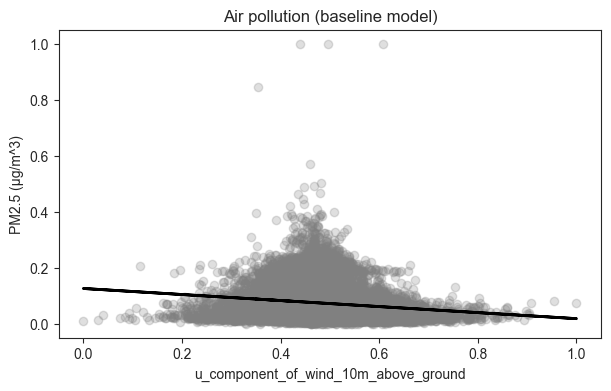

In [78]:
# Plot baseline model
sns.set_style("ticks")
plt.rcParams["figure.figsize"] = (7,4)

plt.scatter(X_train_baseline, y_train, color='grey', alpha=0.25)
plt.plot(X_train_baseline, y_pred_train, '-', color='black', linewidth=2)
plt.title("Air pollution (baseline model)")
plt.ylabel('PM2.5 (µg/m^3)')
#plt.xlabel('L3 HCHO tropospheric HCHO column number density (mol/m^2)');
plt.xlabel(baseline_feature);

### EDA

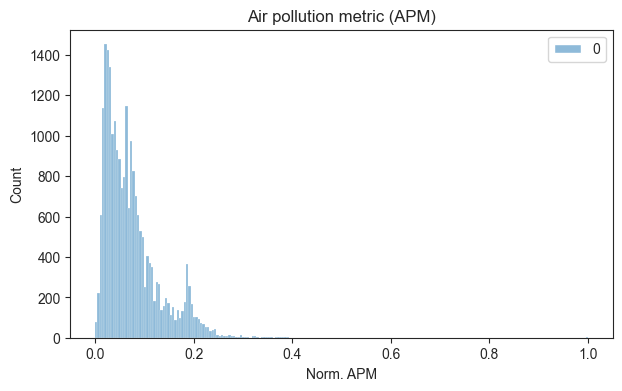

In [87]:
fig = sns.histplot(y_train)
fig.set_title("Air pollution metric (APM)")
fig.set_xlabel("Norm. APM")
fig.set_ylabel("Count")

plt.savefig('apm_hist.png')
plt.show()

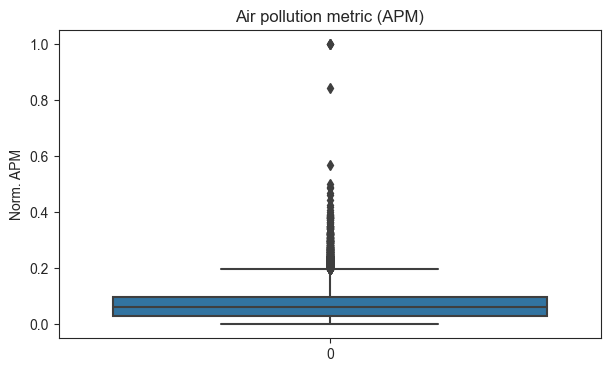

In [88]:
fig = sns.boxplot(y_train)
fig.set_title("Air pollution metric (APM)")
fig.set_xlabel("")
fig.set_ylabel("Norm. APM")

plt.savefig('apm_box.png')
plt.show()

### EDA of sensor features (Humidity, Wind)

In [58]:
eda_df = X_train_imputed.copy()
eda_df["target"] = y_train

#eda_df.info()

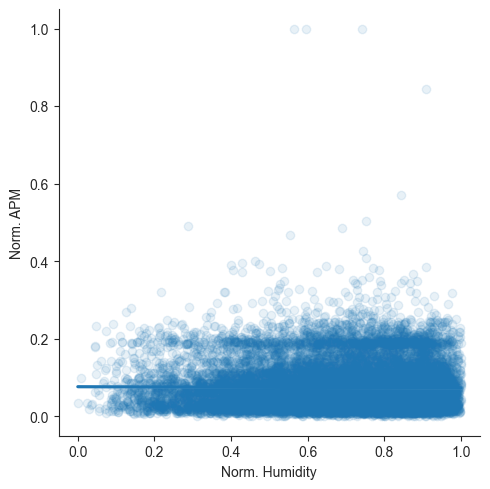

In [89]:
fig = sns.lmplot(data=eda_df, x="relative_humidity_2m_above_ground", y="target", scatter_kws={'alpha':0.1})
fig.set_titles("APM vs. Humidity")
fig.set_axis_labels("Norm. Humidity","Norm. APM")

plt.savefig('humidity.png')
plt.show()

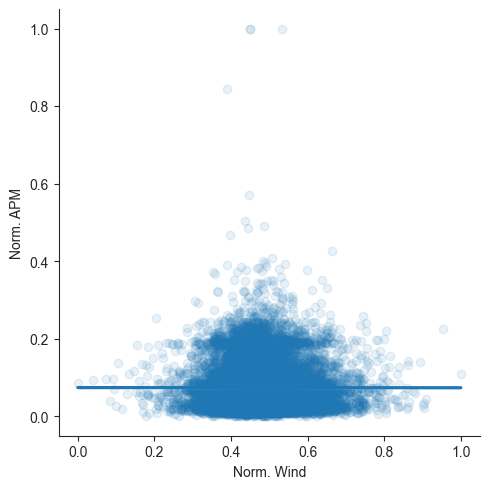

In [90]:
fig = sns.lmplot(data=eda_df, x="u_component_of_wind_10m_above_ground", y="target", scatter_kws={'alpha':0.1})
fig.set_titles("APM vs. Wind")
fig.set_axis_labels("Norm. Wind","Norm. APM")

plt.savefig('wind.png')
plt.show()

### EDA of satellite features (Gases)